In [1]:
import sys
import os
import json

import torch

from pathlib import Path
from typing import Union
from IPython.display import display, HTML

from PIL import Image

import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sys.path.append('../')
from utils.general import non_max_suppression
from analysis_app.utils import draw_annotations

%matplotlib inline
alt.data_transformers.disable_max_rows()

display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
root = Path('/mnt/remote/data/users/thomasssajot/yolo_dataset/traffic_lights_entron_classification/focal_len=650__sensor_size_hw=1200x1920/')

files = list(root.glob('RED_SOLID/sedna/2022-05-25--13-27-18--session_2022_04_09_05_21_52_host_zak_complex_intersections2/*.jpeg'))
print(f'Found {len(files)} images.')
assert all([f.exists() for f in files])

# Filter out UNKNOWN class:
len_before = len(files)
files = [f for f in files if f.parent.parent.parent.name != 'UNKNOWN']
print(f'/!\ WARNING /!\: Removing {len_before - len(files)} images with label `UNKNOWN`')

simplified_mapping = {
    'AMBER_SOLID': 'AMBER_SOLID',
    'GREEN_ARROW_LEFT': 'GREEN_SOLID',
    'GREEN_ARROW_RIGHT': 'GREEN_SOLID',
    'GREEN_ARROW_STRAIGHT': 'GREEN_SOLID',
    'GREEN_SOLID': 'GREEN_SOLID',
    'NONE': 'NONE',
    'RED_AND_AMBER': 'RED_AND_AMBER',
    'RED_ARROW_RIGHT': 'RED_SOLID',
    'RED_ARROW_STRAIGHT': 'RED_SOLID',
    'RED_SOLID': 'RED_SOLID',
    'UNKNOWN': 'UNKNOWN'
}
ground_truth_labels = {str(i): simplified_mapping[str(i.relative_to(root)).split('/')[0]] for i in files}

Found 732 images.
/!\ WARNING /!\: Removing 0 images with label `UNKNOWN`


In [3]:
import torch
model = torch.hub.load(
#         autoshape=False,
        repo_or_dir='/mnt/remote/data/users/thomasssajot/yolov5/',
        model='custom', 
        device='mp_inference:cuda:0',
        path='/mnt/remote/data/users/thomasssajot/yolov5/runs/traffic_light_2020_undistorted/yolov5x6_1280_cross_prod_visible_only/weights/best.pt', 
        source='local'
    ) 
model.eval()

WARNING, select device has been modified: cuda:0
2022-10-24 17:58:56.972 WARNING yolov5: WARNING, select device has been modified: cuda:0
Fusing layers... 
2022-10-24 17:59:07.481 INFO    yolov5: Fusing layers... 
Model summary: 416 layers, 140038156 parameters, 0 gradients, 208.0 GFLOPs
2022-10-24 17:59:12.494 INFO    yolov5: Model summary: 416 layers, 140038156 parameters, 0 gradients, 208.0 GFLOPs
Adding AutoShape... 
2022-10-24 17:59:12.518 INFO    yolov5: Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1

In [4]:
images = [Image.open(f) for f in tqdm(files[:5])]
x = np.stack([np.array(i) for i in images])
x = torch.tensor(x).permute(0, 3, 1, 2)
# p = next(model.parameters())
# x = x.to(model.model.device).type_as(p) / 255

images[0].size, x.shape

  0%|          | 0/5 [00:00<?, ?it/s]

((1920, 1200), torch.Size([5, 3, 1200, 1920]))

In [5]:
image = Image.open(files[0])
image = image.resize((1600, 1000)).crop(box=(0, 0, 1600, 1000 - 40))
image.size, ((1200 - 48) / 1920), 960 / 1600

((1600, 960), 0.6, 0.6)

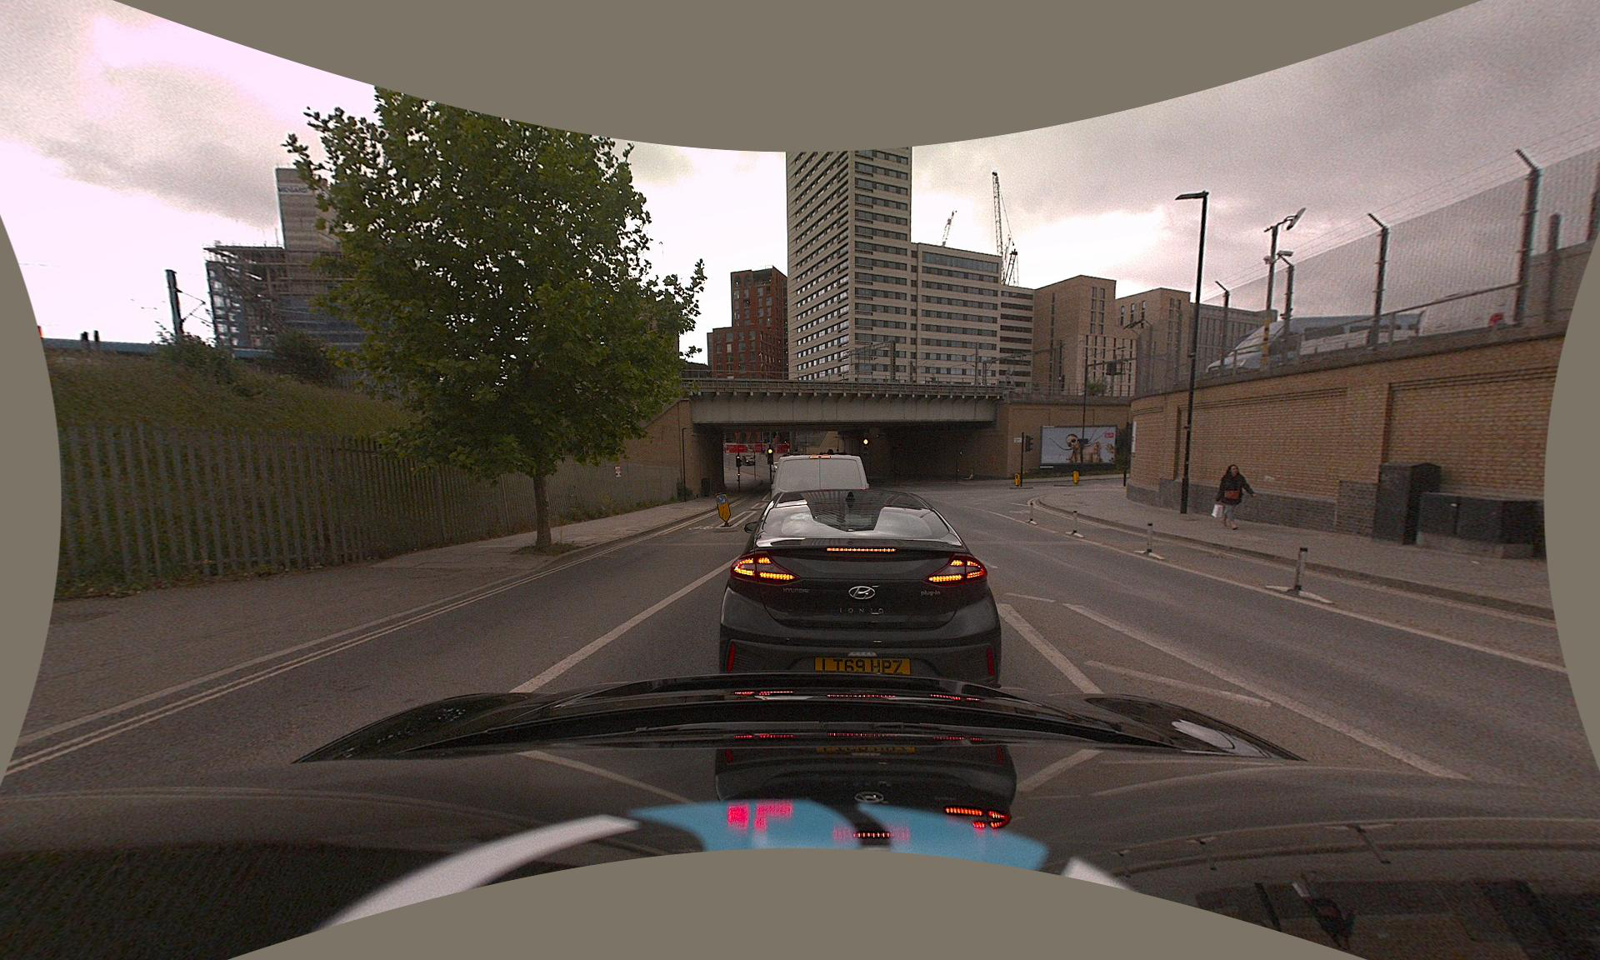

In [67]:
image.crop

In [ ]:
Image.Image.crop()

In [38]:
def rescale_and_pad(image, target_shape):
    b, c, h, w = image.shape
    print(h, w)
    to_h, to_w = target_shape
    
    # Select scaling that will make the original image fit
    scale = min(to_h / h, to_w / w)
    
    return 
    
    

rescale_and_pad(x, (1024, 1600))

1200 1920


(0.8333333333333334, 0.8333333333333334)

In [5]:
res = model(images, size=1280)


gain: 0.6666666666666666
Shape1: [[800.0, 1280.0], [800.0, 1280.0], [800.0, 1280.0], [800.0, 1280.0], [800.0, 1280.0]]
Shape1 is:  [832, 1280]
Shape0 is: [(1200, 1920), (1200, 1920), (1200, 1920), (1200, 1920), (1200, 1920)]
[tensor([[6.88971e+02, 3.63384e+02, 6.96395e+02, 3.79765e+02, 7.55942e-01, 3.00000e+00],
        [6.12312e+02, 3.71643e+02, 6.20077e+02, 3.88238e+02, 5.82910e-01, 1.00000e+00],
        [6.12296e+02, 3.71636e+02, 6.20363e+02, 3.88280e+02, 4.36475e-01, 3.00000e+00]], device='cuda:0'), tensor([[6.89366e+02, 3.63606e+02, 6.96205e+02, 3.78760e+02, 7.02170e-01, 3.00000e+00],
        [6.12468e+02, 3.71987e+02, 6.20045e+02, 3.88506e+02, 5.59108e-01, 3.00000e+00],
        [6.12436e+02, 3.72033e+02, 6.19956e+02, 3.88284e+02, 4.97025e-01, 1.00000e+00]], device='cuda:0'), tensor([[6.12273e+02, 3.71213e+02, 6.20304e+02, 3.88190e+02, 7.89671e-01, 1.00000e+00],
        [6.88938e+02, 3.63522e+02, 6.96538e+02, 3.80319e+02, 5.72947e-01, 3.00000e+00]], device='cuda:0'), tensor([[6.89

In [6]:
model(x[:1]).shape

torch.Size([1, 66300, 13])

In [7]:
y = np.array([[800.0, 1280.0], [800.0, 1280.0], [800.0, 1280.0], [800.0, 1280.0], [800.0, 1280.0]]).max(0)


In [8]:
import math
def make_divisible(x, divisor):
    # Returns nearest x divisible by divisor
    if isinstance(divisor, torch.Tensor):
        divisor = int(divisor.max())  # to int
    return math.ceil(x / divisor) * divisor


In [10]:
import torchvision
from rfa_toolbox import create_graph_from_pytorch_model, visualize_architecture
model = torchvision.models.alexnet()
graph = create_graph_from_pytorch_model(model)
visualize_architecture(
    graph, f"alexnet_32_pixel", input_res=32
).view()

/home/thomassajot/miniconda3/envs/yolov5/lib/python3.9/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1000 / 1000 (100.0%)
Greatest absolute difference: 0.04516908526420593 at index (0, 869) (up to 1e-05 allowed)
Greatest relative difference: 461.9636671222073 at index (0, 712) (up to 1e-05 allowed)
  _check_trace(


%classifier : __torch__.torch.nn.modules.container.___torch_mangle_1155.Sequential = prim::GetAttr[name="classifier"](%self.1)

%avgpool : __torch__.torch.nn.modules.pooling.AdaptiveAvgPool2d = prim::GetAttr[name="avgpool"](%self.1)

%features : __torch__.torch.nn.modules.container.___torch_mangle_1149.Sequential = prim::GetAttr[name="features"](%self.1)

%346 : Tensor = prim::CallMethod[name="forward"](%features, %x.1)

%347 : Tensor = prim::CallMethod[name="forward"](%avgpool, %346)

%247 : int = prim::Constant[value=1]() # /home/thomassajot/miniconda3/envs/yolov5/lib/python3.9/site-packages/torchvision/models/alexnet.py:50:0

%248 : int = prim::Constant[value=-1]() # /home/thomassajot/miniconda3/envs/yolov5/lib/python3.9/site-packages/torchvision/models/alexnet.py:50:0

%input.27 : Float(1, 9216, strides=[9216, 1], requires_grad=1, device=cpu) = aten::flatten(%347, %247, %248) # /home/thomassajot/miniconda3/envs/yolov5/lib/python3.9/site-packages/torchvision/models/alexnet.py:50:0



'.gv.pdf'

In [11]:
res = model(x[:1])
print(res.shape)
preds = non_max_suppression(res, 0.25, 0.45, None, False, False, max_det=1000)
print(len(preds),preds[0].shape)
preds = [x.cpu().detach().numpy() for x in preds]
preds = [pd.DataFrame(x, columns=['x0', 'y0', 'x1', 'y1', 'confidence', 'class']).assign(sample=i) for i, x in enumerate(preds)]
preds = pd.concat(preds)
preds[['x0', 'y0', 'x1', 'y1', 'class']] = preds[['x0', 'y0', 'x1', 'y1', 'class']].astype(int)
preds['name'] = preds['class'].astype(int).map(model.names.get)
preds

Error: no "view" mailcap rules found for type "application/pdf"


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
# import torch
# model = torch.hub.load(
#         repo_or_dir='/mnt/remote/data/users/thomasssajot/yolov5/',
#         model='custom', 
#         device='mp_inference:cuda:0',
#         path='/mnt/remote/data/users/thomasssajot/yolov5/runs/traffic_light_2020_undistorted/yolov5x6_1280_cross_prod_visible_only/weights/best.pt', 
#         source='local'
#     ) 
# model.eval()

res = model(images[0], size=1280)
res.pandas().xyxyn[0]

In [ ]:
Image.fromarray((x[0] * 255).cpu().detach().permute(1, 2, 0).numpy().astype(np.uint8))

In [ ]:
x[0].shape

In [ ]:
res[0].shape

In [ ]:
(res == np.array(images[0]))

In [ ]:
Image.fromarray((res[0] * 255).cpu().detach().permute(1, 2, 0).numpy().astype(np.uint8))

In [ ]:
crop_pad = 100
crops = preds.query('sample == 0').copy(True)
crops[['x0', 'y0']] = (crops[['x0', 'y0']] - crop_pad).clip(0) 
crops[['x1', 'y1']] = (crops[['x1', 'y1']] + crop_pad).clip(upper=(1600, 1024)) 

In [ ]:
for _, (x0, y0, x1, y1) in crops[['x0', 'y0', 'x1', 'y1']].iterrows():
    print((x0, y0, x1, y1))
#     img = images[0].copy()
#     draw_annotations(img, preds.query('sample == 0').copy(True), size=15)

In [ ]:
img.crop(box=(x0, y0, x1, y1))

In [ ]:
img = images[0].copy()
draw_annotations(img, preds.query('sample == 0').copy(True), size=15)
img

In [ ]:
preds.query('sample == 0')